# **9장 합성곱 신경망**
---
* 출판사 : 생능 출판사( http://www.booksr.co.kr/ )
* 으뜸 머신러닝 저자 : 강영민, 박동규, 김성수
*  소스코드 저장소 : https://github.com/dknife/ML2nd
*  저작권 : 본 노트북 코드는 자유롭게 배포가능하지만 위의 출판사, 저서, 저자표기와 함께 배포해 주십시오.
---

### **9.9 전이학습 - 이미 훈련된 모델을 고쳐 쓰기**

In [1]:
# LAB9.3에서 데이터를 읽는 것까지는
# 그대로 진행한 뒤에 전이학습 코드를 새로 작성한다.
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras import models, layers
from keras.models import Model, load_model
import pandas as pd
from keras.optimizers import RMSprop

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train[:10000] / 255.0, x_test[:2000] / 255.0
y_train, y_test = y_train[:10000], y_test[:2000]

x_train_preprocess = np.zeros((x_train.shape[0], 75, 75, 3),
                              dtype=np.float32)
print(x_train_preprocess.shape)

for i, img in enumerate(x_train):
    img_resize = resize(img, (75, 75), anti_aliasing=True)
    x_train_preprocess[i] = np.dstack([img_resize, img_resize, img_resize])

x_test_preprocess = np.zeros((x_test.shape[0], 75, 75, 3),
                             dtype=np.float32)
print(x_test_preprocess.shape)
# 검증 데이터 각각의 크기를 75x75로 변형 (인셉션모델 최소 입력 크기)
for i, img in enumerate(x_test):
    img_resize = resize(img, (75, 75), anti_aliasing=True)
    x_test_preprocess[i] = np.dstack([img_resize, img_resize, img_resize])



11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(10000, 75, 75, 3)
(2000, 75, 75, 3)


In [2]:
# 사전 훈련된 모델을 가져온다. - 이미지넷 데이터로 학습된 모델
pre_trained_model = InceptionV3(input_shape=(75, 75, 3),
                              include_top=False,
                              weights='imagenet')

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [4]:
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(10, activation='softmax')(x)

model = Model(pre_trained_model.input, x)
model.compile(optimizer=RMSprop(learning_rate=0.0005),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 75, 75, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 37, 37,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 37, 37,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 37, 37,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 35, 35,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 35, 35,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 17, 17,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 17, 17,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 17, 17,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 15, 15,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 15, 15,    │          0 │ batch_normalizat

 Total params: 9,418,346 (35.93 MB)

 Trainable params: 443,082 (1.69 MB)

 Non-trainable params: 8,975,264 (34.24 MB)

In [5]:
history = model.fit(x_train_preprocess, y_train, epochs=20,
                    validation_data=(x_test_preprocess, y_test))

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 55ms/step - accuracy: 0.8372 - loss: 0.5527 - val_accuracy: 0.9695 - val_loss: 0.1093
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9740 - loss: 0.0808 - val_accuracy: 0.9630 - val_loss: 0.1087
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9833 - loss: 0.0477 - val_accuracy: 0.9745 - val_loss: 0.0949
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9888 - loss: 0.0362 - val_accuracy: 0.9555 - val_loss: 0.1314
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9893 - loss: 0.0278 - val_accuracy: 0.9700 - val_loss: 0.0928
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9943 - loss: 0.0204 - val_accuracy: 0.9770 - val_loss: 0.0953
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9936 - loss: 0.0194 - val_accuracy: 0.9765 - val_loss: 0.0869
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9948 - loss: 0.0154 - val_acc

In [6]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

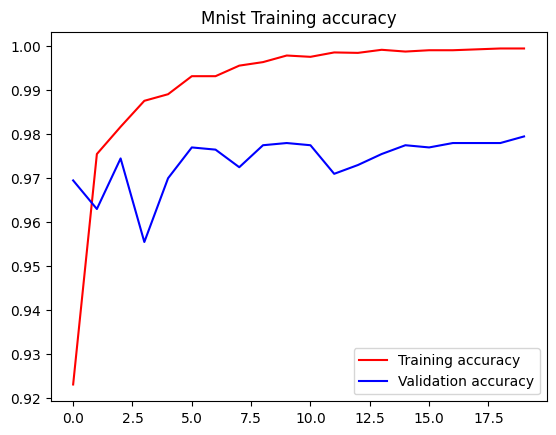

<Figure size 640x480 with 0 Axes>

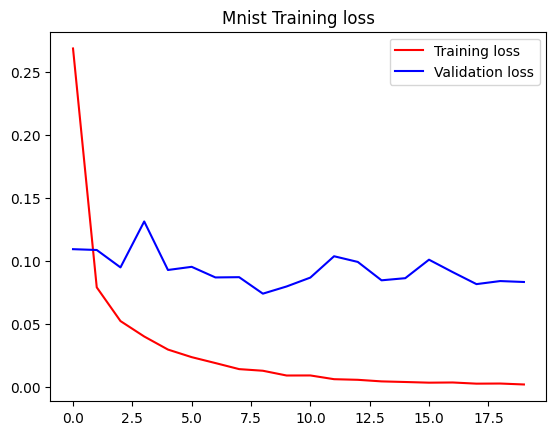

<Figure size 640x480 with 0 Axes>

In [7]:
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title("Mnist Training accuracy")
plt.legend(loc=0)
plt.figure()
plt.show()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title("Mnist Training loss")
plt.legend(loc=0)
plt.figure()
plt.show()